In [1]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import std
from sklearn import preprocessing

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler 
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as MSE

import xgboost as xg

from ale_utils import first_order_aleplot_quant, second_order_aleplot_quant

from sklearn.inspection import PartialDependenceDisplay

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
from hyperopt.pyll_utils import scope

from typing import Dict

### Data Processing

In [2]:
df = pd.read_csv("preprocessed.csv")
df.head(2)

,Unnamed: 0,airline,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,date,DOW
0,206668,Air_India,Delhi,Evening,one,Night,Mumbai,Business,24.75,1,42220,2022-02-11,4
1,206669,Air_India,Delhi,Night,one,Night,Mumbai,Business,26.50,1,44450,2022-02-11,4


In [3]:
df = df.drop(columns=['Unnamed: 0','date'],axis=1)

In [4]:
# one hot encoding
df_boosting = pd.get_dummies(data=df, columns=['airline','source_city',
                                              'departure_time','stops','arrival_time',
                                              'destination_city','class','DOW'])

In [5]:
df_boosting.head(2)

,duration,days_left,price,airline_Air_India,airline_Other,airline_Vistara,source_city_Bangalore,source_city_Chennai,source_city_Delhi,source_city_Hyderabad,...,destination_city_Mumbai,class_Business,class_Economy,DOW_0,DOW_1,DOW_2,DOW_3,DOW_4,DOW_5,DOW_6
0,24.75,1,42220,1,0,0,0,0,1,0,...,1,1,0,0,0,0,0,1,0,0
1,26.50,1,44450,1,0,0,0,0,1,0,...,1,1,0,0,0,0,0,1,0,0


In [5]:
X = df_boosting.drop(['price'], axis=1)
y = df_boosting.price

### Gradient Boosting - XGBRegressor (follow the lab)

In [6]:
from xgboost import XGBRegressor,XGBClassifier
gbm_settings = {'tree_method':'approx','grow_policy':'lossguide','max_depth':0}

In [7]:
# STEP 1: define search space
search_space = {
    'n_estimators': scope.int(hp.qloguniform('n_estimators',np.log(10),np.log(1500),1)), # min: 10, max: 1500 
    'learning_rate': hp.loguniform('learning_rate',np.log(1e-4),np.log(0.5)),
    'max_leaves': scope.int(hp.qloguniform('max_leaves',np.log(2),7*np.log(2),1)), # min: 2, max: 128
    'min_child_weight':scope.int(hp.quniform('min_child_weight',2,100,1)),
    'subsample':hp.uniform('subsample',0.1,1)
}

# STEP2: define loss function

cv = KFold(5,random_state=1,shuffle=True)
train_test_splits = list(cv.split(X))


def cv_rmse(params:Dict):
    K = cv.get_n_splits()
    rmse_folds = [None]*K
    
    for k,(train_index,test_index) in enumerate(train_test_splits):
        
        # fit a xgboost model with the given hyperparameter settings on the training splot
        # NOTE: X is pandas dataframe use the .iloc attribute for extracting the training data
        model_fold = (
            XGBRegressor(**gbm_settings) 
            .set_params(**params) # set hyperparameters
            .fit(X.iloc[train_index,:],y[train_index])
        )
        
        # obtain predictions on the holdout fold
        y_pred_fold = model_fold.predict(X.iloc[test_index,:])
        
        # compute RMSE
        rmse_folds[k] = np.sqrt(mean_squared_error(y[test_index],y_pred_fold))
        
    return {'loss':np.mean(rmse_folds),'status':STATUS_OK} 

# STEP 3: run hyperopt
np.random.seed(123)
trials = Trials() # maintains an optimization history
best = fmin(
    cv_rmse, # loss function
    search_space, # search space
    algo=tpe.suggest,
    max_evals = 30, # number of hyperparameter configurations to explore
    trials=trials,
    return_argmin=False,
    rstate=np.random.default_rng(1)
)
best

100%|█████████████████████████████████████████████| 30/30 [1:40:34<00:00, 201.15s/trial, best loss: 1845.9633389445924]


{'learning_rate': 0.4824817069404312,
 'max_leaves': 22,
 'min_child_weight': 3,
 'n_estimators': 1365,
 'subsample': 0.9840850004419296}

In [9]:
# gather all results
results = pd.DataFrame([
    space_eval(search_space,row.to_dict()) for _,row in pd.DataFrame(trials.vals).iterrows()
]) 

results['RMSE_CV'] = [tmp['loss'] for tmp in trials.results]
results['R2_cv'] = 1-results['RMSE_CV']**2/y.var()

results.sort_values('R2_cv',ascending=False).head(10)

,learning_rate,max_leaves,min_child_weight,n_estimators,subsample,RMSE_CV,R2_cv
20,0.482482,22,3,1365,0.984085,1845.963339,0.993248
5,0.147379,125,3,834,0.642264,1851.625382,0.993207
25,0.240324,116,12,1102,0.437303,2002.060361,0.992058
26,0.481765,19,19,511,0.808891,2093.154450,0.991319
2,0.050968,73,89,804,0.874630,2267.336936,0.989814
29,0.219926,128,19,70,0.344282,2337.519523,0.989174
12,0.010068,99,52,1314,0.477695,2497.481488,0.987641
23,0.067397,12,14,1484,0.977701,2631.652990,0.986278
21,0.433555,24,3,1431,0.141123,2867.453542,0.983709
24,0.045214,27,13,498,0.995074,2895.725379,0.983386


In [10]:
# Final Model
regr_final = (
    XGBRegressor(**gbm_settings) 
    .set_params(**best) # set best hyperparameters from earlier
    .fit(X,y)
)

y_test_pred = regr_final.predict(X)
mses_gb = mean_squared_error(y,y_test_pred)
r2_gb = 1-mses_gb/y.var()

In [11]:
print("training rmse", np.sqrt(mses_gb))
print("training R^2: ", r2_gb)

training rmse 1325.66616586358
training R^2:  0.9965179934307289


In [14]:
feat_imp = regr_final.feature_importances_

# naming the entries using Pandas series
feat_imp_named = pd.Series(feat_imp,index=X.columns.to_list())

# sort in decreasing order of feature importance
feat_imp_named.sort_values(ascending=False).round(4)

class_Business                  0.8361
airline_Air_India               0.0142
destination_city_Delhi          0.0104
source_city_Delhi               0.0093
duration                        0.0075
destination_city_Mumbai         0.0075
airline_Other                   0.0071
source_city_Kolkata             0.0070
source_city_Mumbai              0.0070
source_city_Hyderabad           0.0066
destination_city_Hyderabad      0.0066
destination_city_Kolkata        0.0066
arrival_time_Early_Morning      0.0065
arrival_time_Evening            0.0055
stops_one                       0.0046
stops_two_or_more               0.0044
source_city_Bangalore           0.0042
departure_time_Late_Night       0.0041
destination_city_Chennai        0.0040
arrival_time_Afternoon          0.0040
departure_time_Evening          0.0035
destination_city_Bangalore      0.0035
departure_time_Early_Morning    0.0034
source_city_Chennai             0.0032
departure_time_Morning          0.0028
arrival_time_Late_Night  

<AxesSubplot:title={'center':'Gradient Boosting Feature Importance'}>

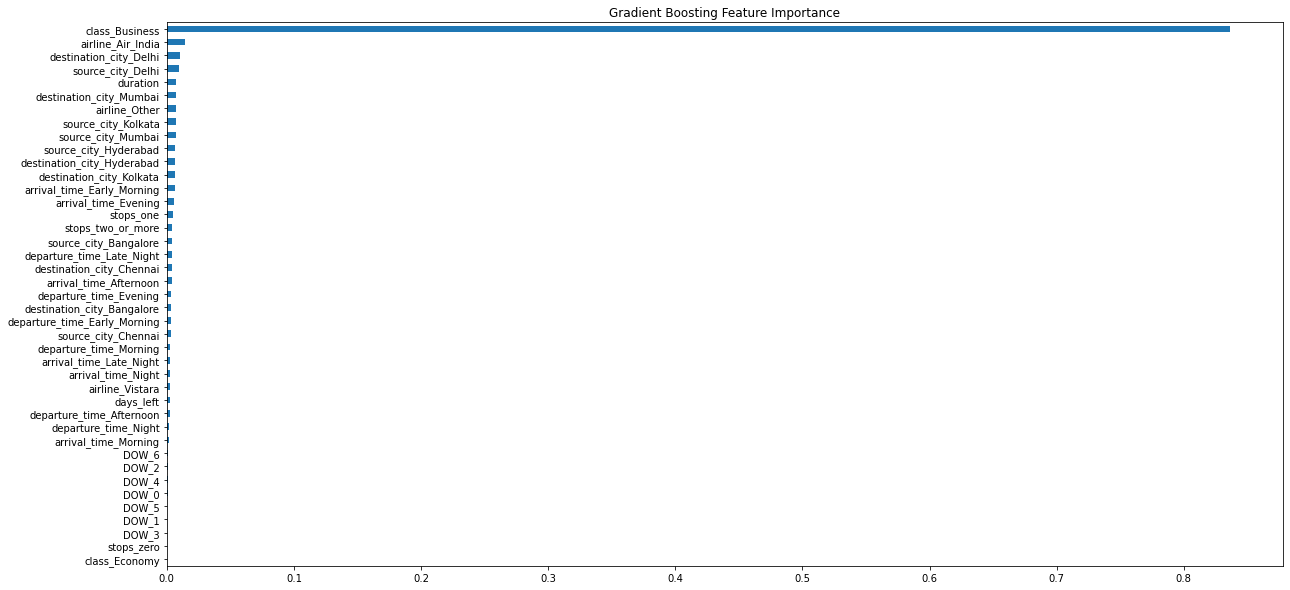

In [16]:
feat_imp_named.sort_values(ascending=True).round(4).plot(kind="barh", title="Gradient Boosting Feature Importance",figsize=(20, 10))

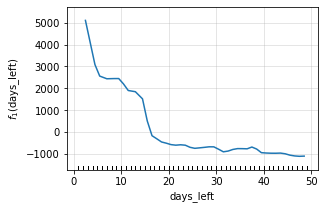

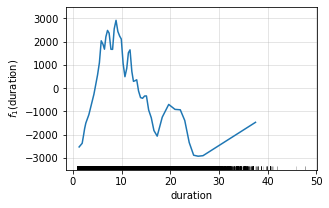

In [17]:
# ALE plot
X_dat = X

fig,ax = plt.subplots(1,1,figsize=(4.5,3))
# plot the first order ALE effects for feature 'days_left'
ax,ale_cement,_ = first_order_aleplot_quant(
    predictor=regr_final.predict, # prediction function
    train_data=X_dat,
    feature='days_left',
    bins=50,ax=ax
)

fig,ax = plt.subplots(1,1,figsize=(4.5,3))
# plot the first order ALE effects for feature 'duration'
ax,ale_cement,_ = first_order_aleplot_quant(
    predictor=regr_final.predict, # prediction function
    train_data=X_dat,
    feature='duration',
    bins=50,ax=ax
)

C:\Users\MENG_YUWE\anaconda3\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical bottom == top == 20276.041015625 results in singular transformations; automatically expanding.
  ax.set_ylim([min_val, max_val])


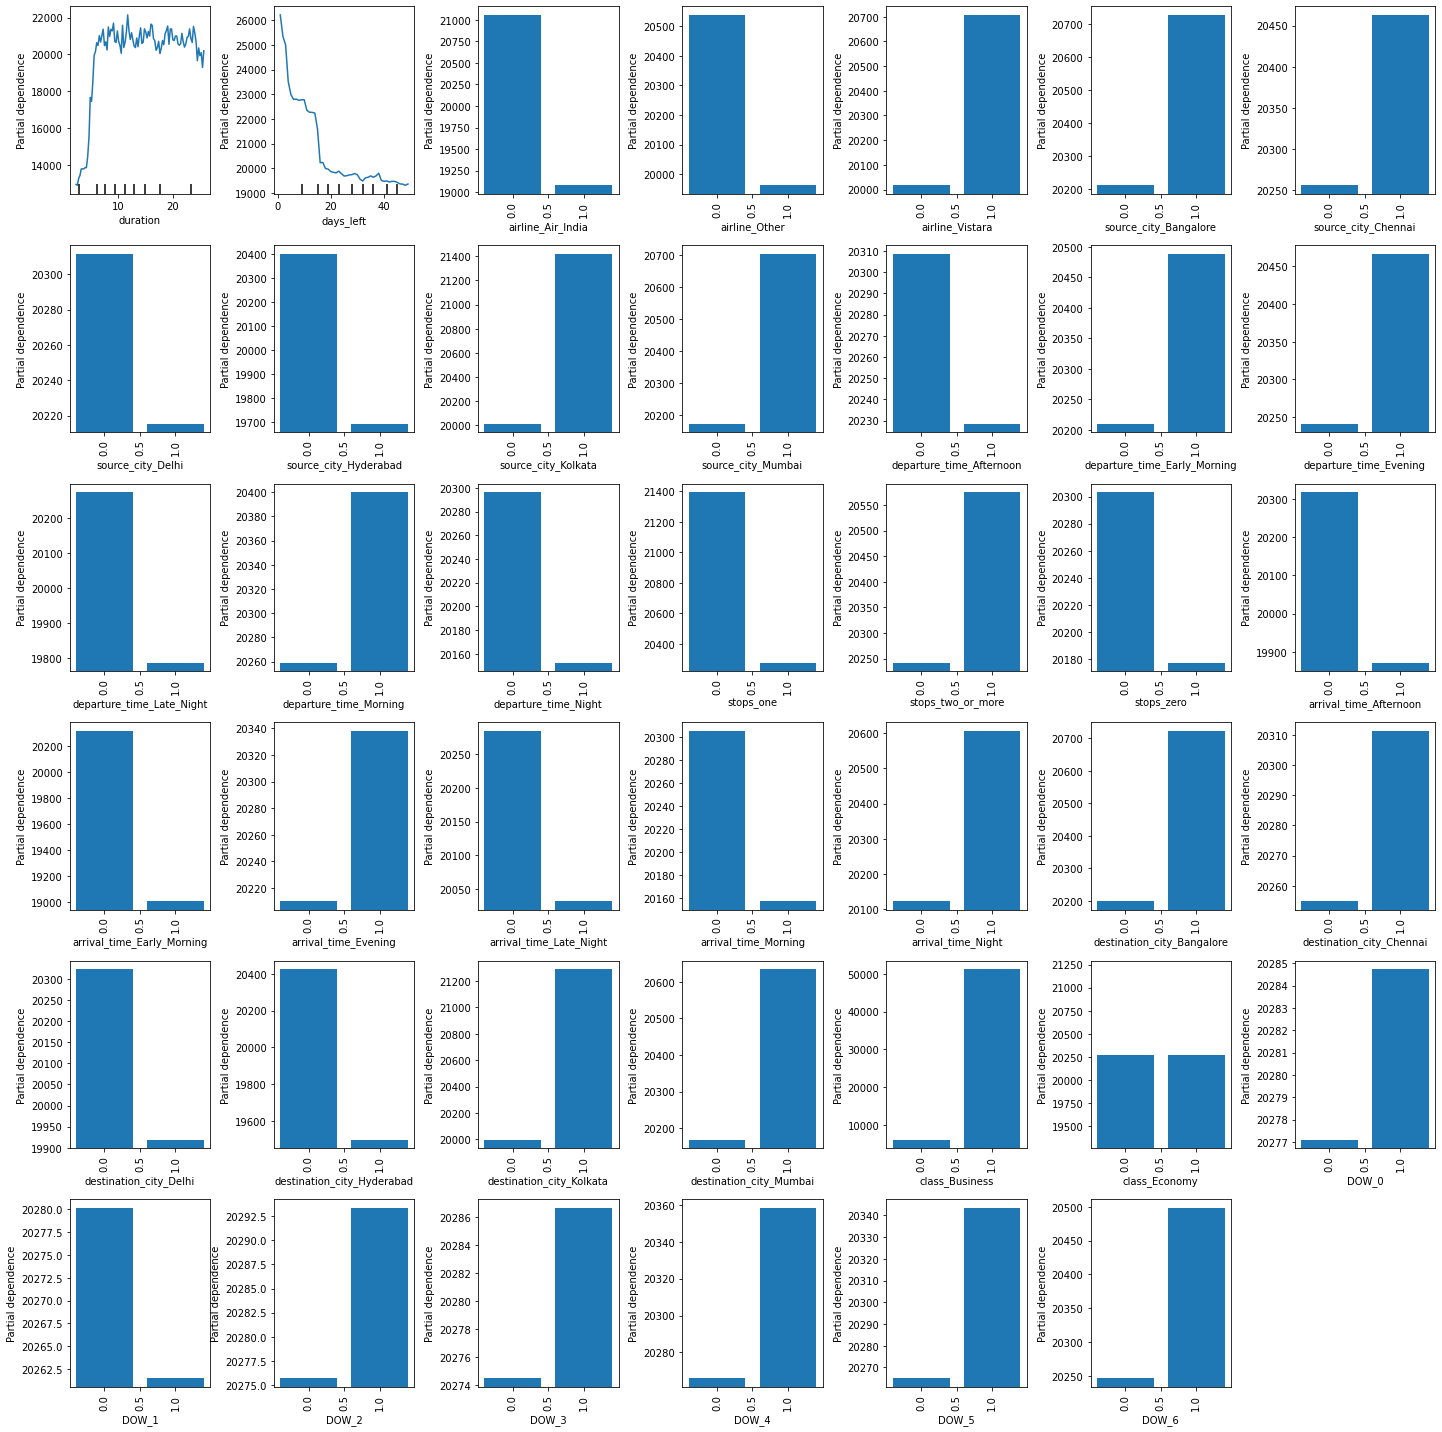

In [22]:
from sklearn.inspection import PartialDependenceDisplay

# 1-D Partial dependence plots
num_rows=6
num_cols=7
fig,axs = plt.subplots(num_rows,num_cols,figsize=(20,20))
fig.delaxes(axs[5,6])
for i in range(num_rows):
    for j in range(num_cols):
        if i==5 and j==6:
            break
        # select correct feature
        features = [X.columns[num_cols*i+j]]
        
        _ = PartialDependenceDisplay.from_estimator(
            estimator=regr_final,
            X=X, # training data
            features=[features],
            #feature_names=X_col_names,
            ax=axs[i,j], 
            categorical_features=X.columns.drop(["duration","days_left"])
        )

fig.tight_layout()

### XGBoost (follow Lab example)

In [30]:
from xgboost import XGBRegressor

gbm_settings = {'tree_method':'approx','grow_policy':'depthwise'}

# STEP 1: define search space
search_space = {
    'n_estimators': scope.int(hp.qloguniform('n_estimators',np.log(800),np.log(1200),1)), # min: 800, max: 1200 
    'learning_rate': hp.loguniform('learning_rate',np.log(1e-4),np.log(0.5)),
    'max_leaves': scope.int(hp.qloguniform('max_leaves',np.log(2),7*np.log(2),1)), # min: 2, max: 128
    'min_child_weight':scope.int(hp.quniform('min_child_weight',2,100,1)),
    'colsample_bytree':hp.uniform('subsample',0.1,1),
    'max_depth':scope.int(hp.qloguniform('max_depth',2*np.log(2),4*np.log(2),1)), # min: 4, max: 16
    'gamma':hp.uniform('gamma',0,1),
    'reg_alpha':hp.uniform('reg_alpha',0,1),
    'reg_lambda':hp.uniform('reg_lambda',0,1)
}

# STEP2: define loss function

cv = KFold(5,random_state=1,shuffle=True)
train_test_splits = list(cv.split(X))


def cv_rmse(params:Dict):
    K = cv.get_n_splits()
    rmse_folds = [None]*K
    
    for k,(train_index,test_index) in enumerate(train_test_splits):
        
        # fit a xgboost model with the given hyperparameter settings on the training splot
        # NOTE: X is pandas dataframe use the .iloc attribute for extracting the training data
        model_fold = (
            XGBRegressor(**gbm_settings) 
            .set_params(**params) # set hyperparameters
            .fit(X.iloc[train_index,:],y[train_index])
        )
        
        # obtain predictions on the holdout fold
        y_pred_fold = model_fold.predict(X.iloc[test_index,:])
        
        # compute RMSE
        rmse_folds[k] = np.sqrt(mean_squared_error(y[test_index],y_pred_fold))
        
    return {'loss':np.mean(rmse_folds),'status':STATUS_OK} 

# STEP 3: run hyperopt
np.random.seed(123)
trials = Trials() # maintains an optimization history
best = fmin(
    cv_rmse, # loss function
    search_space, # search space
    algo=tpe.suggest,
    max_evals = 30, # number of hyperparameter configurations to explore
    trials=trials,
    return_argmin=False,
    rstate=np.random.default_rng(1)
)
best

100%|██████████| 30/30 [11:27<00:00, 22.92s/trial, best loss: 1982.313449258491]


{'colsample_bytree': 0.7519942256585419,
 'gamma': 0.9346178525692137,
 'learning_rate': 0.4640891043041282,
 'max_depth': 11,
 'max_leaves': 68,
 'min_child_weight': 100,
 'n_estimators': 866,
 'reg_alpha': 0.16376286230324713,
 'reg_lambda': 0.2736328304636606}

In [31]:
# gather all results set 1
results = pd.DataFrame([
    space_eval(search_space,row.to_dict()) for _,row in pd.DataFrame(trials.vals).iterrows()
]) 

results['RMSE_CV'] = [tmp['loss'] for tmp in trials.results]
results['R2_cv'] = 1-results['RMSE_CV']**2/y.var()

results.sort_values('R2_cv',ascending=False).head(10)

,colsample_bytree,gamma,learning_rate,max_depth,max_leaves,min_child_weight,n_estimators,reg_alpha,reg_lambda,RMSE_CV,R2_cv
20,0.751994,0.934618,0.464089,11,68,100,866,0.163763,0.273633,1982.313449,0.992214
26,0.995574,0.886354,0.302337,13,61,76,920,0.107707,0.229504,1993.390605,0.992127
21,0.418561,0.999147,0.309764,12,83,99,876,0.077759,0.289120,2136.831864,0.990953
24,0.771403,0.875184,0.277043,12,42,71,957,0.139624,0.064706,2155.126431,0.990797
23,0.409326,0.984639,0.455917,11,64,98,883,0.133393,0.271499,2176.834466,0.990611
0,0.559123,0.457663,0.096354,15,79,3,877,0.555094,0.346294,2269.679846,0.989793
28,0.976976,0.816547,0.185213,16,29,93,915,0.087177,0.180659,2452.979307,0.988078
27,0.975221,0.882946,0.056276,13,58,79,1004,0.186737,0.382875,2498.758163,0.987629
10,0.735704,0.422416,0.145002,8,26,90,828,0.220705,0.489666,2706.929955,0.985482
25,0.444973,0.869055,0.044029,10,87,99,861,0.001425,0.004056,2741.998010,0.985103


In [23]:
regr_final = (
    XGBRegressor(**gbm_settings) 
    .set_params(**best) # set best hyperparameters from earlier
    .fit(X,y)
)

In [24]:
y_test_pred = regr_final.predict(X)
mses_gb = mean_squared_error(y,y_test_pred)
r2_gb = 1-mses_gb/y.var()

print("training rmse", np.sqrt(mses_gb))
print("training R^2: ", r2_gb)

training rmse 1528.1404249022785
training R^2:  0.9953731249561739


In [33]:
feat_imp = regr_final.feature_importances_

# naming the entries using Pandas series
feat_imp_named = pd.Series(feat_imp,index=X.columns.to_list())

# sort in decreasing order of feature importance
feat_imp_named.sort_values(ascending=False).round(4)

class_Business                  0.6999
airline_Vistara                 0.0619
airline_Air_India               0.0571
airline_Other                   0.0280
stops_zero                      0.0272
stops_two_or_more               0.0215
stops_one                       0.0109
source_city_Mumbai              0.0066
destination_city_Hyderabad      0.0058
duration                        0.0054
source_city_Kolkata             0.0054
source_city_Delhi               0.0053
source_city_Hyderabad           0.0050
destination_city_Delhi          0.0048
destination_city_Kolkata        0.0047
destination_city_Bangalore      0.0045
arrival_time_Evening            0.0043
destination_city_Mumbai         0.0043
days_left                       0.0043
arrival_time_Early_Morning      0.0031
arrival_time_Night              0.0027
source_city_Chennai             0.0027
departure_time_Evening          0.0027
class_Economy                   0.0026
destination_city_Chennai        0.0026
source_city_Bangalore    

Text(0.5, 0, 'XGBoost Regressor Feature Importance')

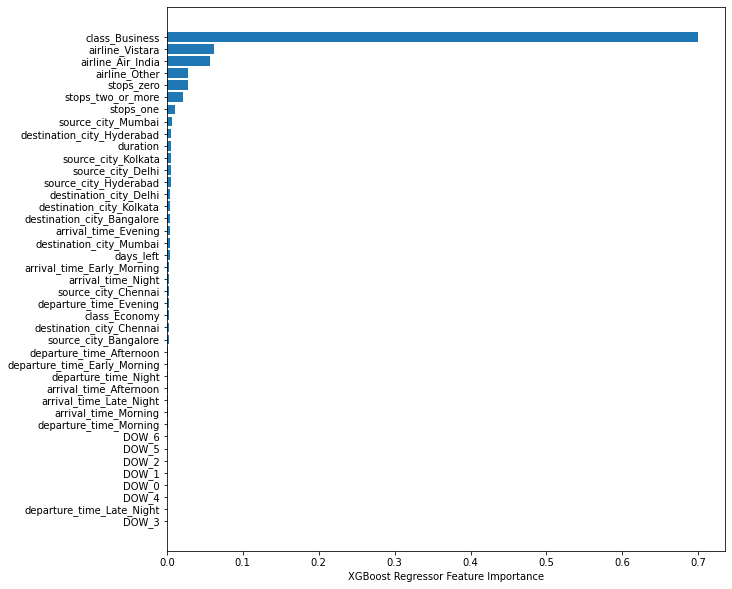

In [42]:
sorted_gbidx = regr_final.feature_importances_.argsort()
plt.figure(figsize=(10, 10))
plt.barh(X.columns[sorted_gbidx], regr_final.feature_importances_[sorted_gbidx])
plt.xlabel("XGBoost Regressor Feature Importance")

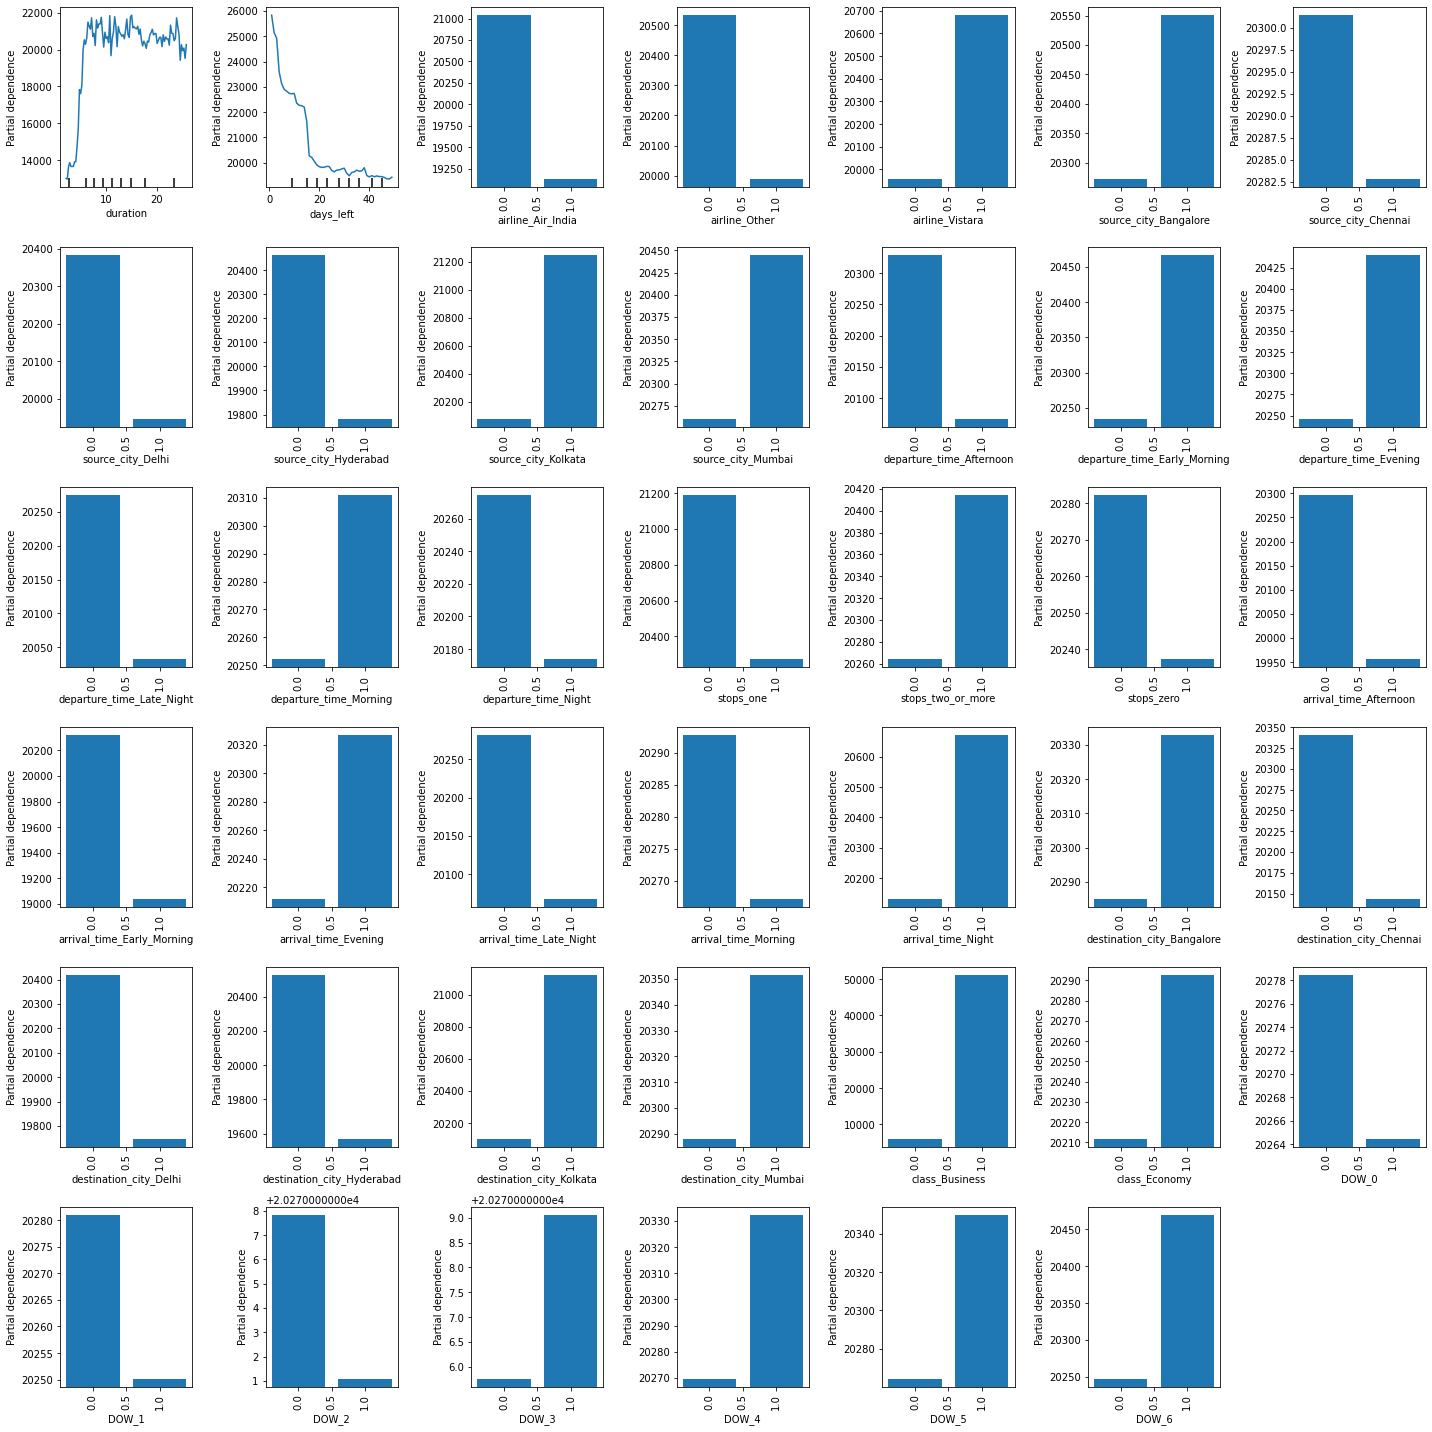

In [26]:
from sklearn.inspection import PartialDependenceDisplay

# 1-D Partial dependence plots
num_rows=6
num_cols=7
fig,axs = plt.subplots(num_rows,num_cols,figsize=(20,20))
fig.delaxes(axs[5,6])
for i in range(num_rows):
    for j in range(num_cols):
        if i==5 and j==6:
            break
        # select correct feature
        features = [X.columns[num_cols*i+j]]
        
        _ = PartialDependenceDisplay.from_estimator(
            estimator=regr_final,
            X=X, # training data
            features=[features],
            #feature_names=X_col_names,
            ax=axs[i,j], 
            categorical_features=X.columns.drop(["duration","days_left"])
        )

fig.tight_layout()